# Introduction


In the realm of digitizing handwritten information, the transformation of diverse scripts into a format understandable by computers poses a significant challenge. This task, encountered in both physical documents and digital platforms, is crucial for unlocking valuable data embedded within handwritten scripts. The intricate nature of handwriting, influenced by factors such as age, language, and mental state, necessitates advanced machine learning techniques for accurate recognition.

Traditionally, handwritten recognition relied on methods like K-nearest neighbors and Support Vector Machines. However, recent advancements have propelled techniques like transfer learning and deep neural networks, particularly Convolutional Neural Networks (CNNs), to the forefront. CNNs have proven highly effective in handling the intricacies of handwritten recognition, offering specialized capabilities for diverse scripts.

Our focus lies in Arabic Handwritten Character Recognition (AHCR) using CNNs, where the Arabic script's unique features, such as right-to-left writing and connected letters, present distinct challenges. With 28 unique characters and variations based on their positions in words, AHCR demands tailored approaches.

This project explores four distinct methods for classifying Arabic characters using CNNs, each designed to address specific challenges:

1. Custom CNN Model: A specialized CNN architecture tailored to the nuances of Arabic script, capturing positional dependencies and connectivity between characters.

2. Custom CNN Model with Data Augmentation: Building upon the custom model, this approach incorporates data augmentation techniques to create variations in the training dataset. This is essential for handling the diverse handwriting styles and positions of characters within words.

3. Well-Known CNN Architectures (LeNet-5) with Data Augmentation: Utilizing established CNN architectures, such as LeNet-5, and enhancing their performance with data augmentation techniques to adapt them for AHCR.

4. Pre-Trained CNN with Data Augmentation: Leveraging transfer learning, this method involves using a pre-trained CNN on a different task and fine-tuning it for AHCR. Data augmentation is applied to further enhance the model's ability to generalize across diverse handwriting styles.

In the subsequent discussion, we delve into the specifics of CNNs, the importance of data augmentation, and the benefits of transfer learning in the context of AHCR.

# Needed Libraries

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, Input, AveragePooling2D

# Preprocessing the dataset

## Dataset

Dataset can be found [here](https://drive.google.com/file/d/1ZQ8fSD6WgkXFBKIxMRBMn0-gTwzFjUvz/view?usp=sharing
). It consists of 4 csv files, Training set and their labels, Testing set and their labels. Each row represents the pixels of the image, 1024 pixels, whic can be converted to 32x32. The training file consists of 13340 images and the testing file consist of 3360 images. If you want to run the code, make sure to upload all of the 4 files, and change the path in the code.

## The dictionary of the Arabic alphabets

In [88]:
# Hashing the values of the alphabets
arabic_alphabet = {
    0: 'ا',
    1: 'ب',
    2: 'ت',
    3: 'ث',
    4: 'ج',
    5: 'ح',
    6: 'خ',
    7: 'د',
    8: 'ذ',
    9: 'ر',
    10: 'ز',
    11: 'س',
    12: 'ش',
    13: 'ص',
    14: 'ض',
    15: 'ط',
    16: 'ظ',
    17: 'ع',
    18: 'غ',
    19: 'ف',
    20: 'ق',
    21: 'ك',
    22: 'ل',
    23: 'م',
    24: 'ن',
    25: 'ه',
    26: 'و',
    27: 'ي'
}

## Reading the data and splitting it into Training, Validation, and Testing sets

In [89]:
X_train = pd.read_csv("/kaggle/input/vision-dataset/csvTrainImages 13440x1024.csv")
y_train = pd.read_csv("/kaggle/input/vision-dataset/csvTrainLabel 13440x1.csv")
X_test = pd.read_csv("/kaggle/input/vision-dataset/csvTestImages 3360x1024.csv")
y_test = pd.read_csv("/kaggle/input/vision-dataset/csvTestLabel 3360x1.csv")

## Normalizing the images

In [90]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

## Finding the number of classes and categorizing the y values 

In [91]:
num_classes = len(np.unique(y_train)) # The number of classes, which is 28 for the Arabic alphabets.
y_train = to_categorical(y_train - 1, num_classes) # -1 for zero indexing, from (1 -> 28) to (1 -> 27)
y_test = to_categorical(y_test - 1, num_classes)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (13439, 1024)
13439 train samples
3359 test samples


## Reshaping the X values.

Since each image is an array of 1024 pixels, we will reshape it into 32 x 32 images.

In [92]:
X_train = np.array(X_train).reshape(-1, 32, 32, 1)
y_train = np.array(y_train)

X_test = np.array(X_test).reshape(-1, 32, 32, 1)
y_test = np.array(y_test)

# Task 1

## Creating the model

The Convolutional Neural Network (CNN) architecture designed for image classification follows a sequential structure. The input layer receives grayscale images with dimensions 32×32 pixels and a batch size of 128. The model comprises various convolutional layers, pooling layers, dropout layers, dense layers, and fully connected layers.

1. Input Layer: 
    * Shape: 32 × 32 × 1 32×32×1 (grayscale images) 
    * Batch Size: 128 


2. Convolutional Layers: 
    * First Conv2D layer with 3 filters of size 3×3, ReLU activation, and 'same' padding. 
    * Second Conv2D layer with 128 filters of size 3×3 and ReLU activation. 
    * MaxPooling2D layer with a pool size of 3×3. 
    * Third Conv2D layer with 256 filters of size 3×3 and ReLU activation. 
    * Dropout layer with a dropout rate of 0.2. 
    * Fourth Conv2D layer with 256 filters of size 3×3, ReLU activation, 'same' padding, and strides of 2. 
    * MaxPooling2D layer with a pool size of 2×2. 
    * Fifth Conv2D layer with 512 filters of size 3×3, ReLU activation, and 'same' padding. 
    * Dropout layer with a dropout rate of 0.2. 
    * Sixth Conv2D layer with 1024 filters of size 2×2, ReLU activation, and 'same' padding. 
    * MaxPooling2D layer with a pool size of 2×2. 
    
    
3. Fully Connected Layers: 
    * Flatten layer to transform the 2D output to a 1D vector. 
    * Dense layer with 1024 neurons and SELU activation. 
    * Output layer with the number of neurons equal to the number of classes, using the softmax activation function for classification.
    

- The batch size is a hyperparameter that defines the number of samples to be processed in one iteration during training of a neural network.


- Same padding is a technique used in convolutional neural networks (CNNs) to ensure that the spatial dimensions of the input and output feature maps remain the same after applying a convolutional layer. In other words, it pads the input with zeros in such a way that the output has the same height and width as the input.


- ReLU stands for Rectified Linear Unit, and it is an activation function commonly used in neural networks, including Convolutional Neural Networks (CNNs).

- Softmax activation is a mathematical function that is often used in the output layer of a neural network for multi-class classification problems. It transforms the raw output scores (logits) from the previous layer into a probability distribution over multiple classes.

- The model has 14 layers as the following:
    1. Conv2D Layers:       6 layers
    2. MaxPooling2D Layers: 3 layers
    3. Dropout Layers:      2 layers
    4. Flatten Layer:       1 layer
    5. Dense Layers:        2 layers

In [93]:
def create_model():
    CNN_model = Sequential()
    CNN_model.add(Input(shape=(32, 32, 1), batch_size=128, name='Input'))
    CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
    CNN_model.add(Conv2D(128, (3,3), activation='relu'))
    CNN_model.add(MaxPool2D((3,3)))
    CNN_model.add(Conv2D(256, (3,3), activation='relu'))
    CNN_model.add(Dropout(0.2))
    CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
    CNN_model.add(MaxPool2D((2,2)))
    CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    CNN_model.add(Dropout(0.2))
    CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
    CNN_model.add(MaxPool2D(2,2))
    CNN_model.add(Flatten())
    CNN_model.add(Dense(1024, activation='selu'))
    CNN_model.add(Dense(num_classes, activation='softmax'))
    return CNN_model

This function plots training and validation loss vs epoch, and training and avlidation accuracy vs epoch.

In [94]:
def plot_hist(hist_to_plot):
    plt.figure(figsize=(12, 4))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(hist_to_plot.history['loss'], label='Training Loss')
    plt.plot(hist_to_plot.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation loss Vs Epoch')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist_to_plot.history['accuracy'], label='Training Accuracy')
    plt.plot(hist_to_plot.history['val_accuracy'], label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Vs Epoch')
    plt.legend()

    plt.show()

## Running the model

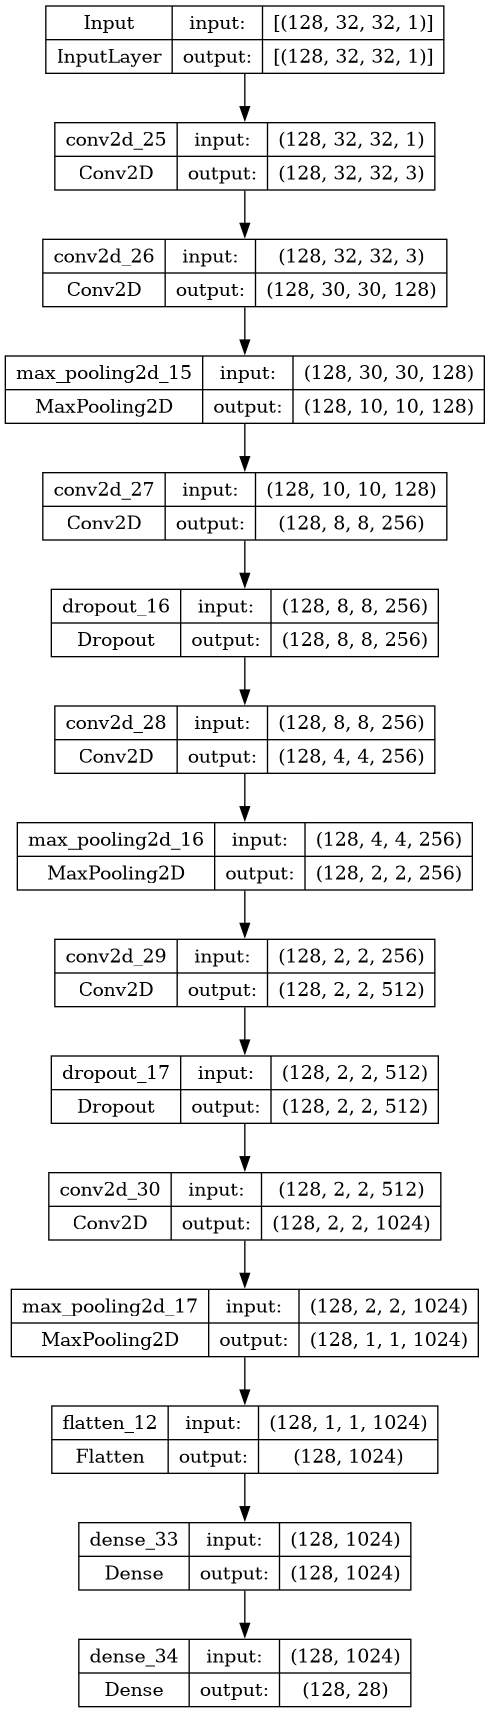

In [95]:
# Create a new model using the defined architecture
model1 = create_model()
tf.keras.utils.plot_model(model1, show_shapes=True)

In this project, we will monitor the validation accuracy for early stopping, giving it patience of 15, to reduce the overfitting, and to see when the models will reach a stable state.

Epoch 1/300


2024-01-25 23:05:08.736752: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


105/105 [==============================] - 5s 25ms/step - loss: 2.1105 - accuracy: 0.3080 - val_loss: 1.2157 - val_accuracy: 0.5389
Epoch 2/300
105/105 [==============================] - 2s 17ms/step - loss: 0.7678 - accuracy: 0.7274 - val_loss: 0.5249 - val_accuracy: 0.8181
Epoch 3/300
105/105 [==============================] - 2s 17ms/step - loss: 0.4370 - accuracy: 0.8481 - val_loss: 0.4111 - val_accuracy: 0.8541
Epoch 4/300
105/105 [==============================] - 2s 17ms/step - loss: 0.2768 - accuracy: 0.9068 - val_loss: 0.2944 - val_accuracy: 0.9131
Epoch 5/300
105/105 [==============================] - 2s 18ms/step - loss: 0.2006 - accuracy: 0.9351 - val_loss: 0.2580 - val_accuracy: 0.9146
Epoch 6/300
105/105 [==============================] - 2s 17ms/step - loss: 0.1417 - accuracy: 0.9509 - val_loss: 0.2274 - val_accuracy: 0.9294
Epoch 7/300
105/105 [==============================] - 2s 17ms/step - loss: 0.1320 - accuracy: 0.9547 - val_loss: 0.1973 - val_accuracy: 0.9425
Epoc

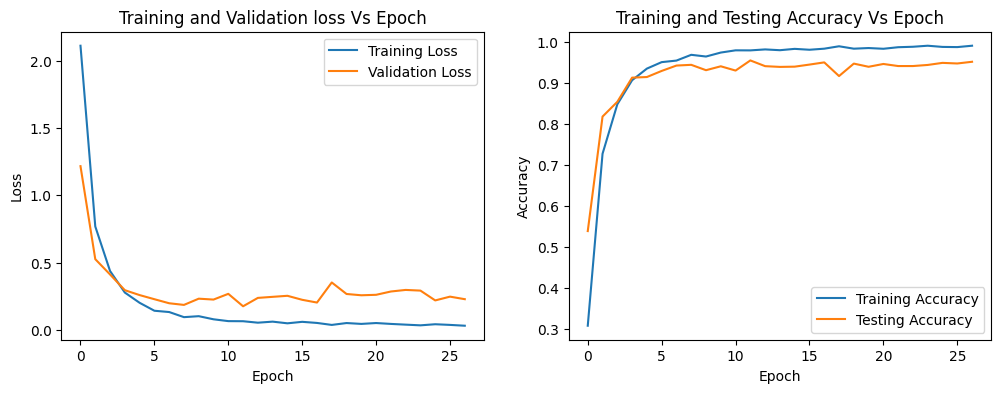

Training Accuracy: 99.46%
Testing Accuracy: 95.50%


In [96]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data with validation data, using a batch size of 128, for 100 epochs
hist1 = model1.fit(X_train, y_train, batch_size=128, epochs=300, validation_data=(X_test, y_test), verbose=1, shuffle=True, 
                  callbacks=[early_stopping])

# Plot the training history (accuracy and loss over epochs)
plot_hist(hist1)

# Evaluate and print the training accuracy
train_loss1, train_accuracy1 = model1.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy1*100:.2f}%")

# Evaluate and print the testing accuracy
test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_accuracy1*100:.2f}%")


The training accuracy is very high, at 99.46%, but the testing accuracy is slightly lower, at 95.50%. This suggests that the model might be overfitting. Overfitting is when a model learns the training data too well, but is not able to generalize to new data. But the overall accuracy is high and good for classifying. We also used Early Stopping and monitored val_accuracy with patience 15, if no updates happen to val_accuracy within 15 epochs, it will stop. We reached 27 epochs before going to this state.

This function plots some of the results

In [97]:
def plot_results(testing_x, testing_y, predictions, number_of_plots=10):
    plt.figure(figsize=(15, 6))
    total = 0
    for i in range(len(testing_x)):
        if arabic_alphabet[testing_y[i]] != arabic_alphabet[predictions[i]]:
            continue
        
        plt.subplot(2, 5, total+1)
        plt.imshow((testing_x[i] * 255).reshape(32,32).T, cmap='gray')
        plt.title(f"True: {arabic_alphabet[testing_y[i]]}\nPredicted: {arabic_alphabet[predictions[i]]}")
        plt.axis('off')
        total += 1
        if total == number_of_plots:
            break

    plt.show()
    
    plt.figure(figsize=(15, 6))
    total = 0
    for i in range(len(testing_x)):
        if arabic_alphabet[testing_y[i]] == arabic_alphabet[predictions[i]]:
            continue
        
        plt.subplot(2, 5, total+1)
        plt.imshow((testing_x[i] * 255).reshape(32,32).T, cmap='gray')
        plt.title(f"True: {arabic_alphabet[testing_y[i]]}\nPredicted: {arabic_alphabet[predictions[i]]}")
        plt.axis('off')
        total += 1
        if total == number_of_plots:
            break

    plt.show()

Making the predictions for the testing set to plot some of it and to plot the confusion matrix. The predicction returns an array of size 28 for each prediction, each with a probability of the image being a character, we take the maximum index in this array and classify the image as the character corresponding to that index.

105/105 [==============================] - 0s 2ms/step


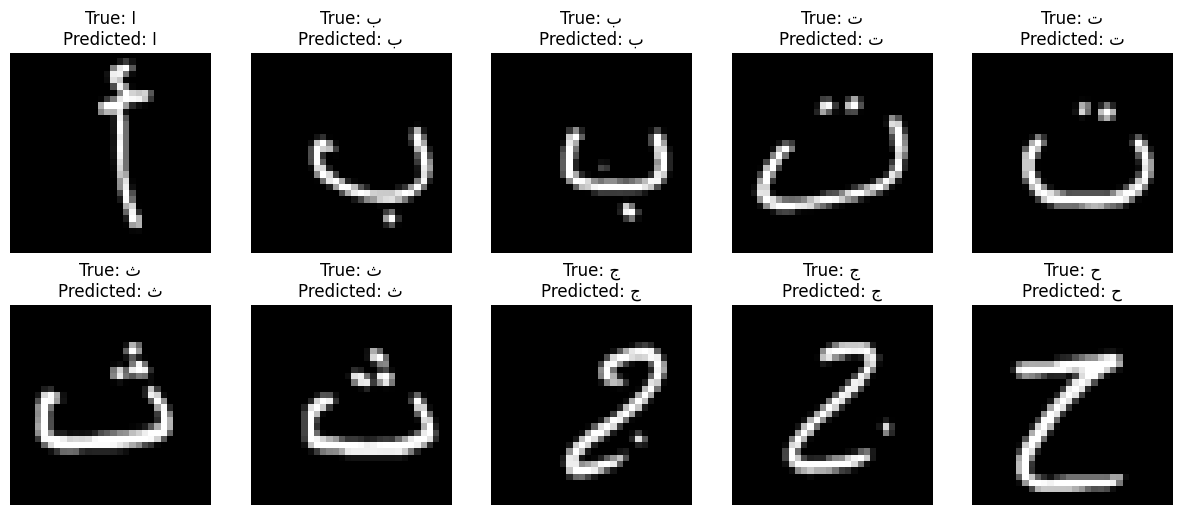

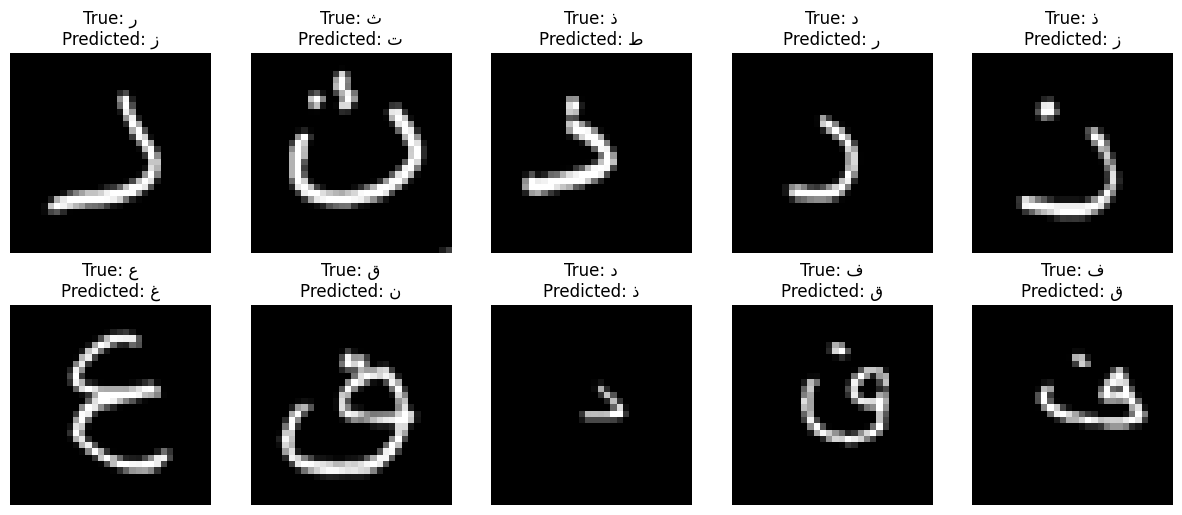

In [98]:
predictions1 = model1.predict(X_test)
predicted_labels1 = np.argmax(predictions1, axis=1)
plot_results(X_test, np.argmax(y_test, axis=1), predicted_labels1)

We can see correct predictions in the first 10 images and wrong predictions in the second 10 images.

And here, we plot the confusion matrix using the predictions and the true classes.

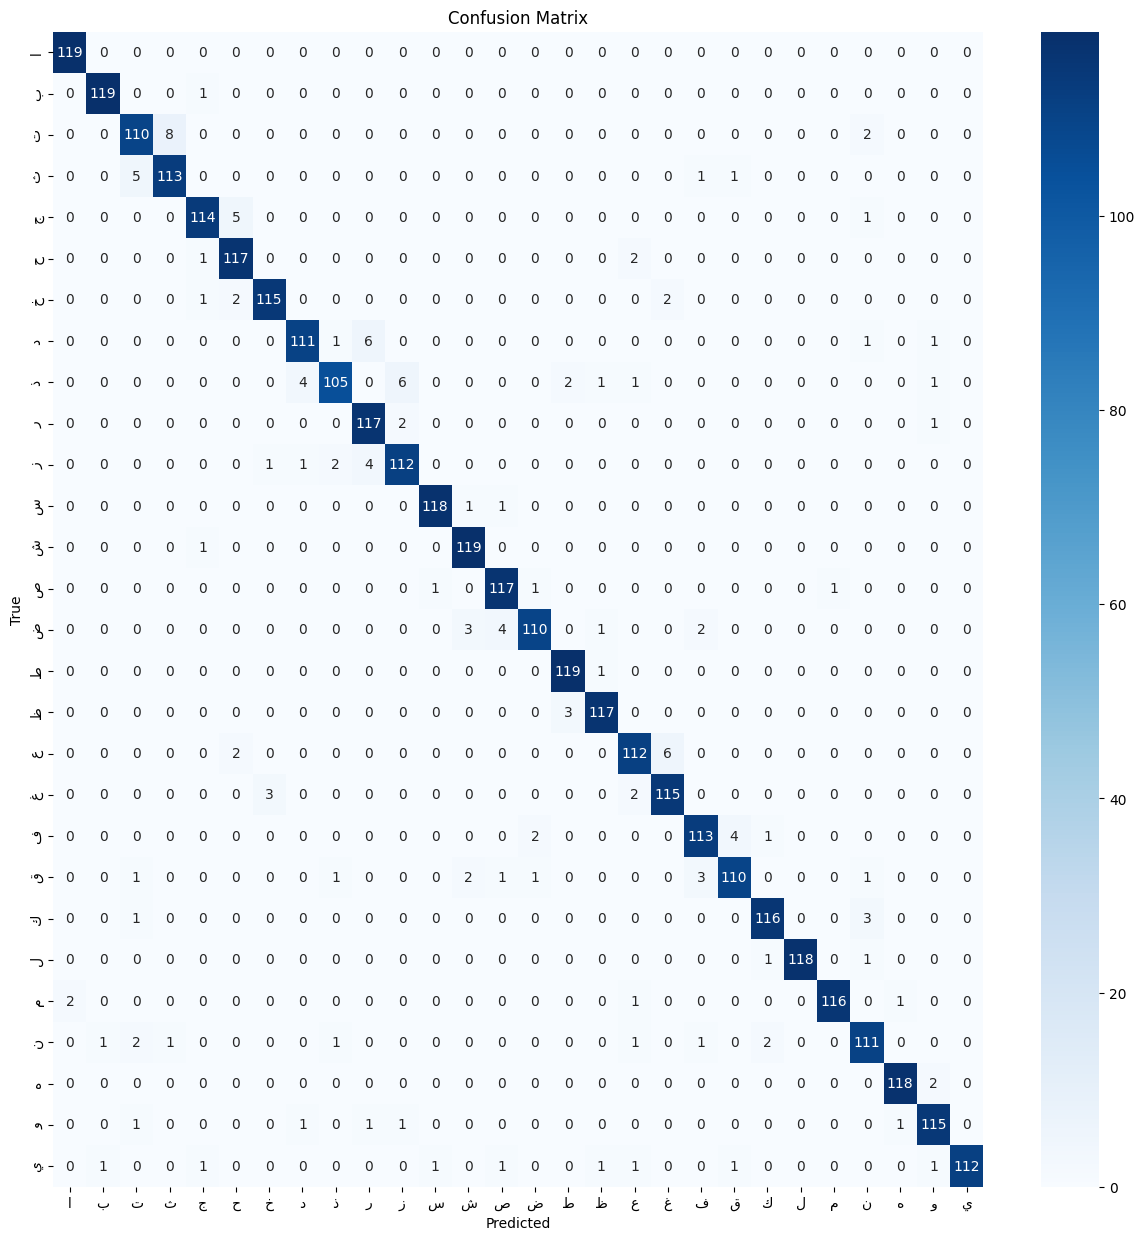

In [99]:
lis = np.argmax(y_test, axis=1)
y_true1 = [arabic_alphabet[idx] for idx in lis]
predicted_labels1_hash = [arabic_alphabet[idx] for idx in predicted_labels1]

cm = confusion_matrix(y_true1, predicted_labels1_hash)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_true1)), yticklabels=sorted(set(y_true1)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

For each row, we can see the number of predicted classes for each class, the majority falls in true classes, which is good, but can be improved.

# Task 2

## Data augmentation

Data augmentation is an integral process in deep learning, as in deep learning we need large amounts of data and in some cases it is not feasible to collect thousands or millions of images, so data augmentation comes to the rescue. It helps us to increase the size of the dataset and introduce variability in the dataset.

The most commonly used operations are
* Rotation     
* Shearing     
* Zooming     
* Cropping     
* Flipping     
* Changing the brightness level

## Running the model


In the context of our dataset, and after trying a lot of operations, the best ones were:
* Rotation Range = 10
* Zoom range = 0.1
* Width Shift Range = 0.1
* Height Shift Range = 0.1

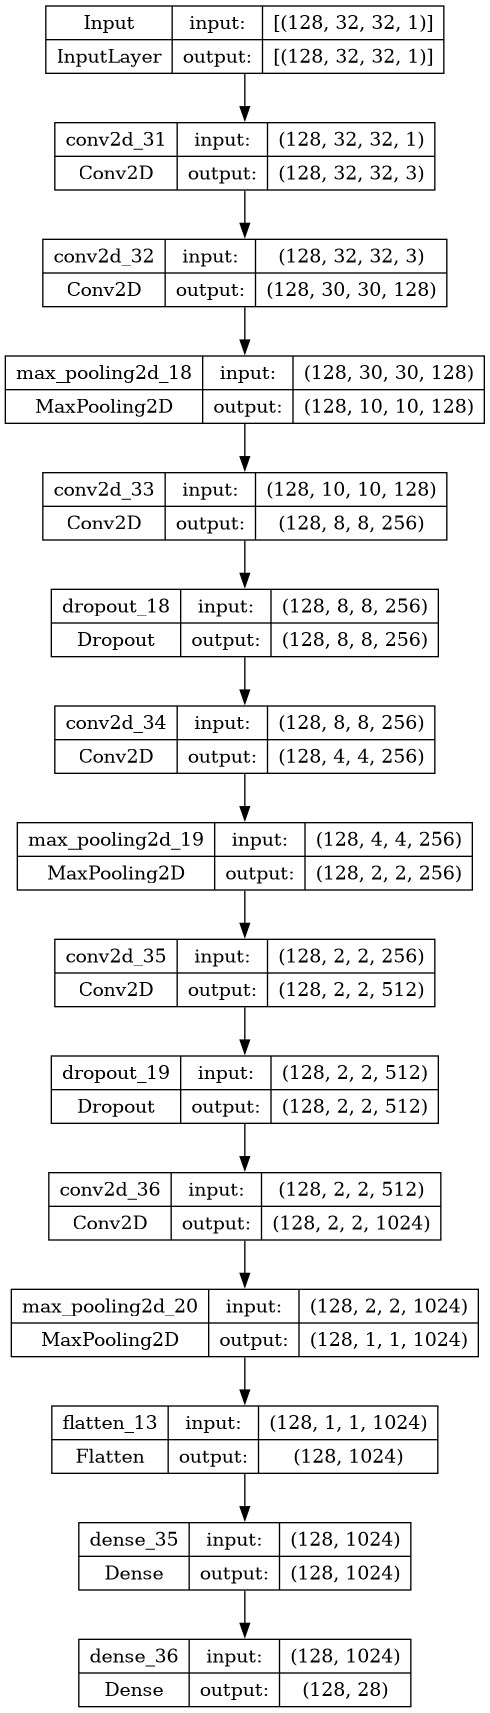

In [100]:
# Create a new model using the defined architecture
model2 = create_model()
tf.keras.utils.plot_model(model2, show_shapes=True)

Epoch 1/300


2024-01-25 23:06:07.810073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


104/104 [==============================] - 8s 49ms/step - loss: 2.4225 - accuracy: 0.2295 - val_loss: 1.3532 - val_accuracy: 0.4912
Epoch 2/300
104/104 [==============================] - 5s 47ms/step - loss: 1.0499 - accuracy: 0.6118 - val_loss: 0.6566 - val_accuracy: 0.7520
Epoch 3/300
104/104 [==============================] - 5s 48ms/step - loss: 0.6625 - accuracy: 0.7637 - val_loss: 0.4024 - val_accuracy: 0.8571
Epoch 4/300
104/104 [==============================] - 5s 47ms/step - loss: 0.4972 - accuracy: 0.8300 - val_loss: 0.4523 - val_accuracy: 0.8392
Epoch 5/300
104/104 [==============================] - 5s 46ms/step - loss: 0.4245 - accuracy: 0.8527 - val_loss: 0.2947 - val_accuracy: 0.9080
Epoch 6/300
104/104 [==============================] - 5s 47ms/step - loss: 0.3533 - accuracy: 0.8789 - val_loss: 0.2374 - val_accuracy: 0.9232
Epoch 7/300
104/104 [==============================] - 5s 47ms/step - loss: 0.2936 - accuracy: 0.9004 - val_loss: 0.1962 - val_accuracy: 0.9357
Epoc

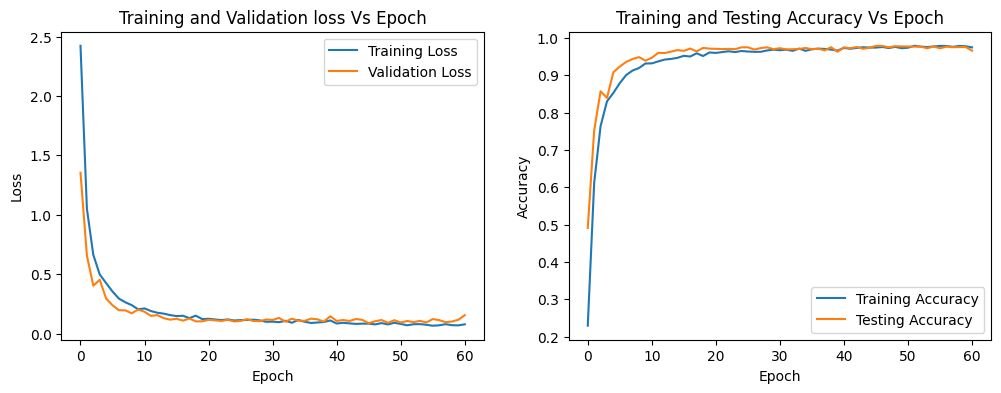

Training Accuracy: 98.92%
Testing Accuracy: 97.86%


In [101]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Image data augmentation using an ImageDataGenerator
image_generator2 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
image_generator2.fit(X_train)  # Fit the image data generator on the training data

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Training the model with augmented data
hist2 = model2.fit(
    image_generator2.flow(X_train, y_train, batch_size=128),  # Generate augmented batches
    steps_per_epoch=len(X_train) / 128,  # Number of batches per epoch
    epochs=300,  # Number of training epochs
    validation_data=(X_test, y_test),  # Validation data
    verbose=1,  # Print training progress
    callbacks= [early_stopping]
)

# Plot the training history
plot_hist(hist2)

# Evaluate the model on the training set
train_loss2, train_accuracy2 = model2.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy2 * 100:.2f}%')

# Evaluate the model on the testing set
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test, verbose=0)
print(f'Testing Accuracy: {test_accuracy2 * 100:.2f}%')


The application of data augmentation to the images resulted in noticeable improvement. The training accuracy reaching 99.92% suggests the model is highly proficient in classifying examples from the training dataset. A testing accuracy of 97.86% indicates strong generalization to new, unseen data, showcasing the model's effectiveness on the testing set. Augmenting the data yielded superior results in terms of accuracy and overfitting reduction, with higher testing accuracy and improved generalization. The augmentation introduced more variability by incorporating diverse transformations like rotation and shifting, allowing the model to learn more robust features. This increased variability required more epochs (61) compared to the custom CNN (27) to reach a stable state. Overall, the augmentation outperformed the custom model, demonstrating its efficacy in enhancing model performance and reducing overfitting.

Plotting some matches and mismatches.

105/105 [==============================] - 0s 2ms/step


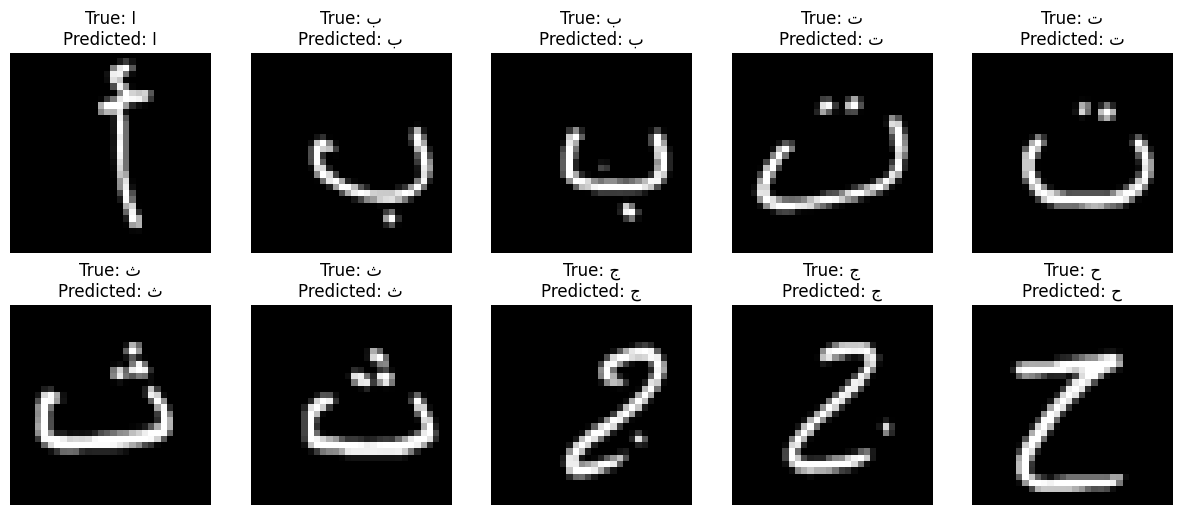

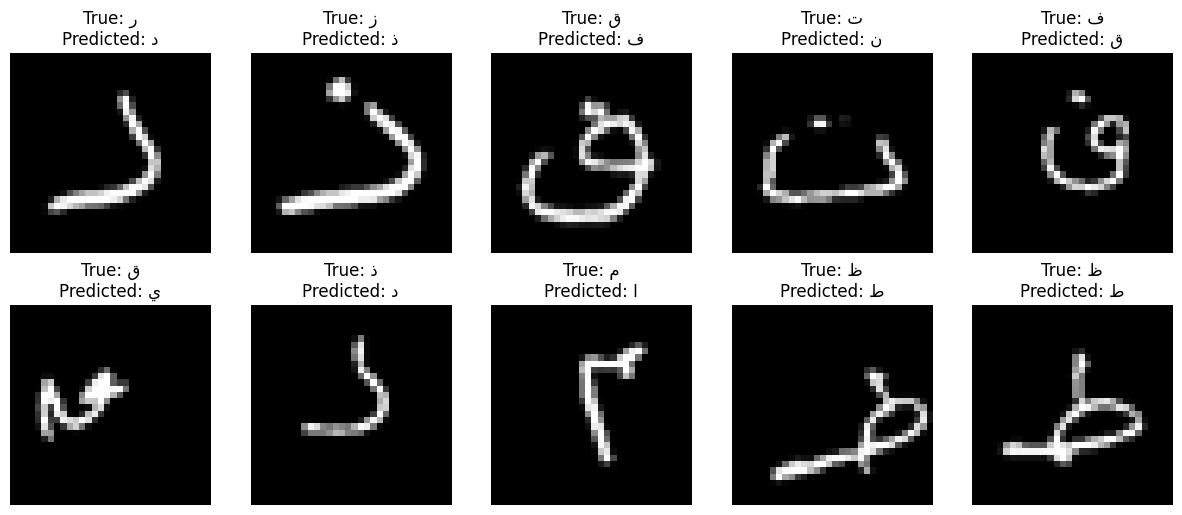

In [102]:
predictions2 = model2.predict(X_test)
predicted_labels2 = np.argmax(predictions2, axis=1)
plot_results(X_test, np.argmax(y_test, axis=1), predicted_labels2)

We can see correct predictions in the first 10 images and wrong predictions in the second 10 images.

Plotting the confusion matrix.

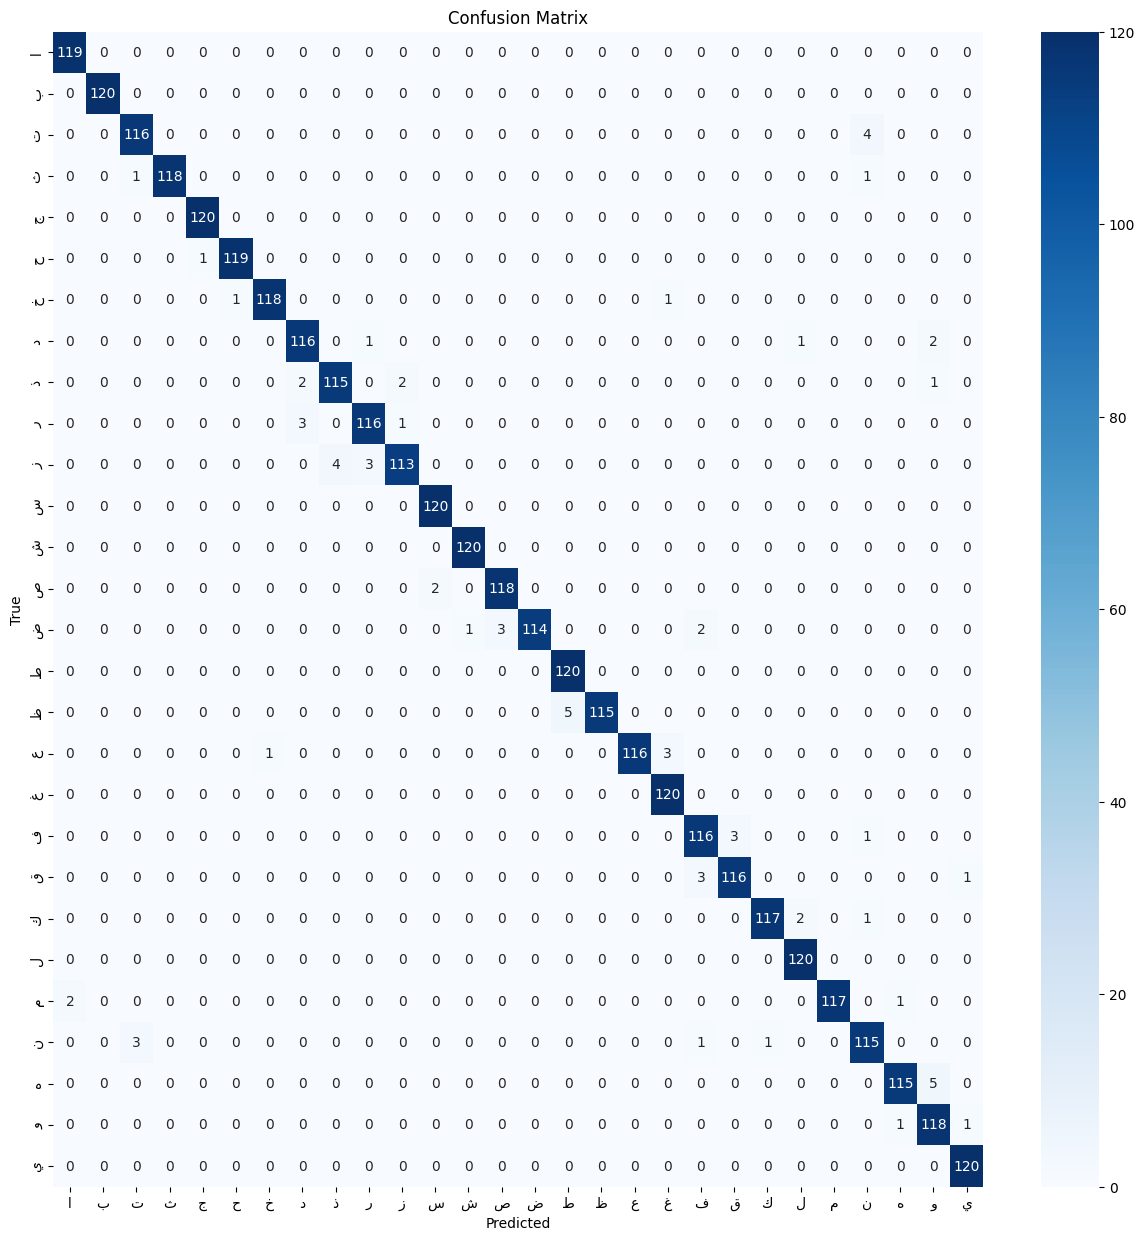

In [103]:
predicted_labels2_hash = [arabic_alphabet[idx] for idx in predicted_labels2]

cm = confusion_matrix(y_true1, predicted_labels2_hash)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_true1)), yticklabels=sorted(set(y_true1)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Task 3

## LeNet introduction

For this task, we tried several architectures like ResNet and GoogleNet, but the one that resulted the best was LeNet-5, so we chose to use it in this task. The implementation of the architecture of this model was taken from [here](https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/#h-architecture-details). Lenet-5 is one of the earliest pre-trained models proposed by Yann LeCun and others in the year 1998, in the research paper Gradient-Based Learning Applied to Document Recognition. They used this architecture for recognizing the handwritten and machine-printed characters.

In [104]:
def build_lenet(input_shape):
    # Create a sequential model
    lenet = Sequential()

    # Layer 1: Convolutional layer with 6 filters, a 5x5 kernel, tanh activation, and 'same' padding
    lenet.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', input_shape=(32, 32, 1), padding='same'))

    # Layer 2: Average pooling layer with a 2x2 pool size and valid padding
    lenet.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

    # Layer 3: Convolutional layer with 16 filters, a 5x5 kernel, tanh activation, and valid padding
    lenet.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='valid'))

    # Layer 4: Average pooling layer with a 2x2 pool size and valid padding
    lenet.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

    # Layer 5: Convolutional layer with 120 filters, a 5x5 kernel, tanh activation, and valid padding
    lenet.add(Conv2D(filters=120, kernel_size=5, strides=1, activation='tanh', padding='valid'))

    # Flatten the output to a 1D array
    lenet.add(Flatten())

    # Layer 6: Fully connected layer with 84 units and tanh activation
    lenet.add(Dense(units=84, activation='tanh'))

    # Layer 7: Fully connected layer with 28 units and softmax activation (assuming it's a classification task)
    lenet.add(Dense(units=28, activation='softmax'))

    # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
    lenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return lenet

## Running the model with augmentaion.

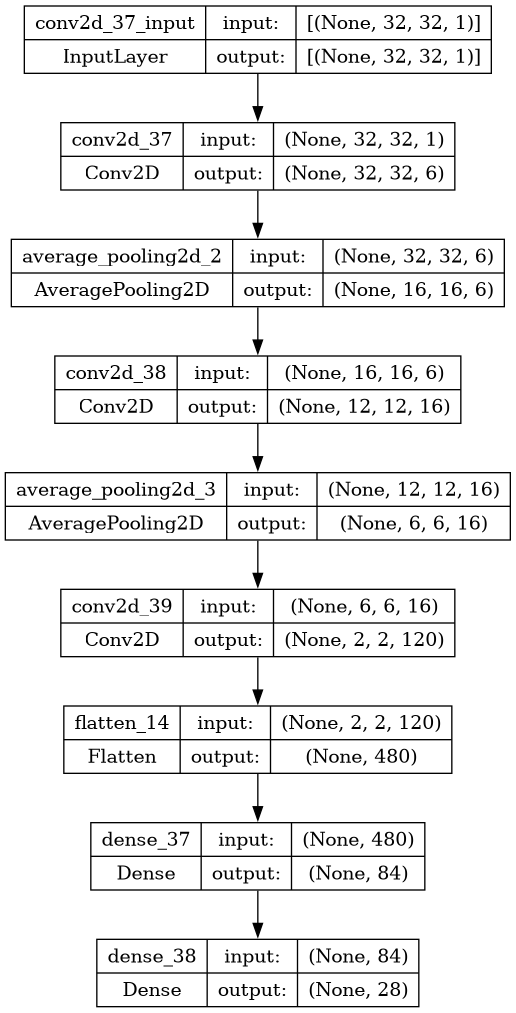

In [105]:
# Create a LeNet-like model with input shape (32, 32, 1)
model3 = build_lenet((32, 32, 1))
tf.keras.utils.plot_model(model3, show_shapes=True)

Epoch 1/300
104/104 [==============================] - 6s 43ms/step - loss: 2.7132 - accuracy: 0.1988 - val_loss: 2.1009 - val_accuracy: 0.3370
Epoch 2/300
104/104 [==============================] - 4s 41ms/step - loss: 2.1425 - accuracy: 0.3421 - val_loss: 1.6779 - val_accuracy: 0.4793
Epoch 3/300
104/104 [==============================] - 5s 44ms/step - loss: 1.7543 - accuracy: 0.4512 - val_loss: 1.3538 - val_accuracy: 0.5817
Epoch 4/300
104/104 [==============================] - 4s 40ms/step - loss: 1.4512 - accuracy: 0.5373 - val_loss: 1.1425 - val_accuracy: 0.6338
Epoch 5/300
104/104 [==============================] - 5s 45ms/step - loss: 1.2198 - accuracy: 0.6023 - val_loss: 0.9897 - val_accuracy: 0.6770
Epoch 6/300
104/104 [==============================] - 4s 41ms/step - loss: 1.0728 - accuracy: 0.6483 - val_loss: 0.8306 - val_accuracy: 0.7327
Epoch 7/300
104/104 [==============================] - 4s 42ms/step - loss: 0.9517 - accuracy: 0.6900 - val_loss: 0.7562 - val_accuracy:

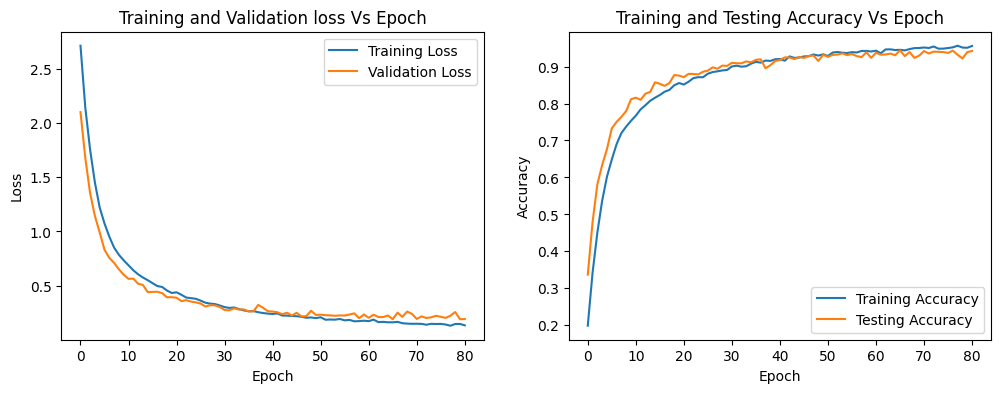

Training Accuracy: 97.27%
Testing Accuracy: 94.40%


In [106]:
# Create an image data generator with various augmentations
image_generator3 = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1)

# Fit the image data generator on the training data
image_generator3.fit(X_train)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Train the model using the image data generator
hist3 = model3.fit(image_generator3.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train) / 128, epochs=300,
                    validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Plot the training history
plot_hist(hist3)

# Evaluate the trained model on the training set
train_loss3, train_accuracy3 = model3.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy3 * 100:.2f}%')

# Evaluate the trained model on the test set
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test, verbose=0)
print(f'Testing Accuracy: {test_accuracy3 * 100:.2f}%')

The model's accuracy is slightly lower than those achieved in tasks 1 and 2, which can be attributed to the specific architecture of the LeNet model used. It appears that the model has reached its optimal performance given the dataset and architecture constraints. However, the achieved 97.27% training accuracy and 94.40% testing accuracy are still commendable, and the absence of overfitting, as indicated by the comparable accuracies, is noteworthy. Despite these achievements, it's acknowledged that there might be room for further improvement with alternative augmentations, but the current results represent the best attainable performance with the chosen architecture. Regarding the increased number of epochs (81) for training the LeNet model, this can be attributed to the complexity of the model and its capacity to capture intricate features. The extended training duration allowed the model to learn more nuanced patterns in the data, contributing to improved accuracy, albeit requiring more epochs to converge effectively.

105/105 [==============================] - 0s 2ms/step


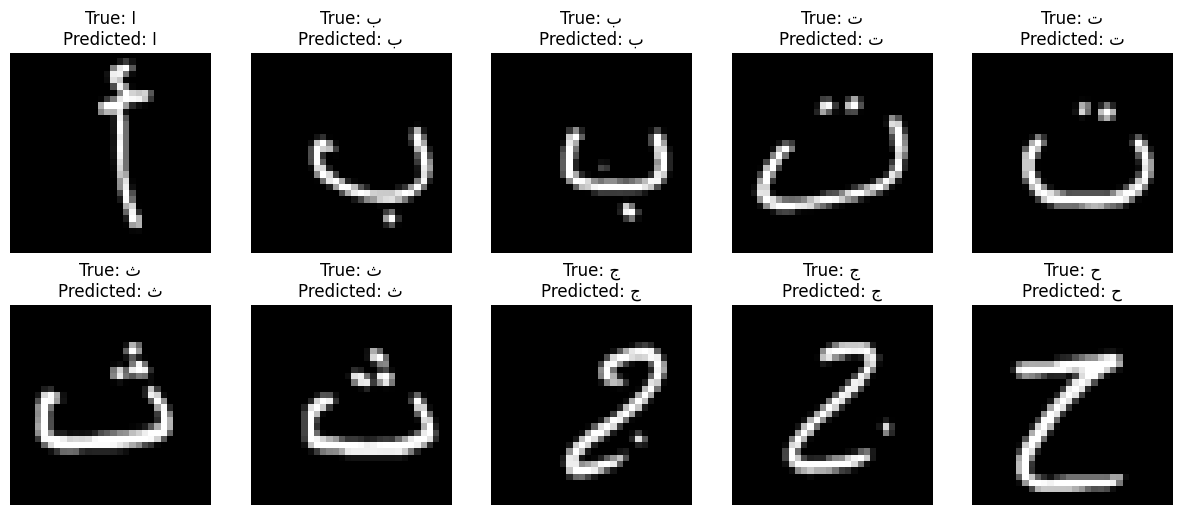

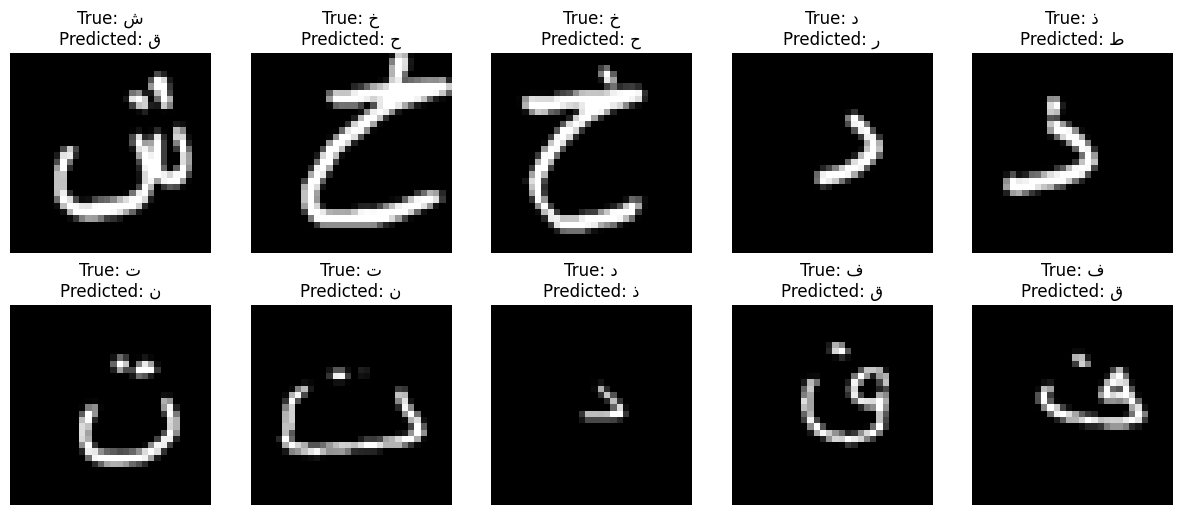

In [107]:
predictions3 = model3.predict(X_test)
predicted_labels3 = np.argmax(predictions3, axis=1)
plot_results(X_test, np.argmax(y_test, axis=1), predicted_labels3)

We can see correct predictions in the first 10 images and wrong predictions in the second 10 images.

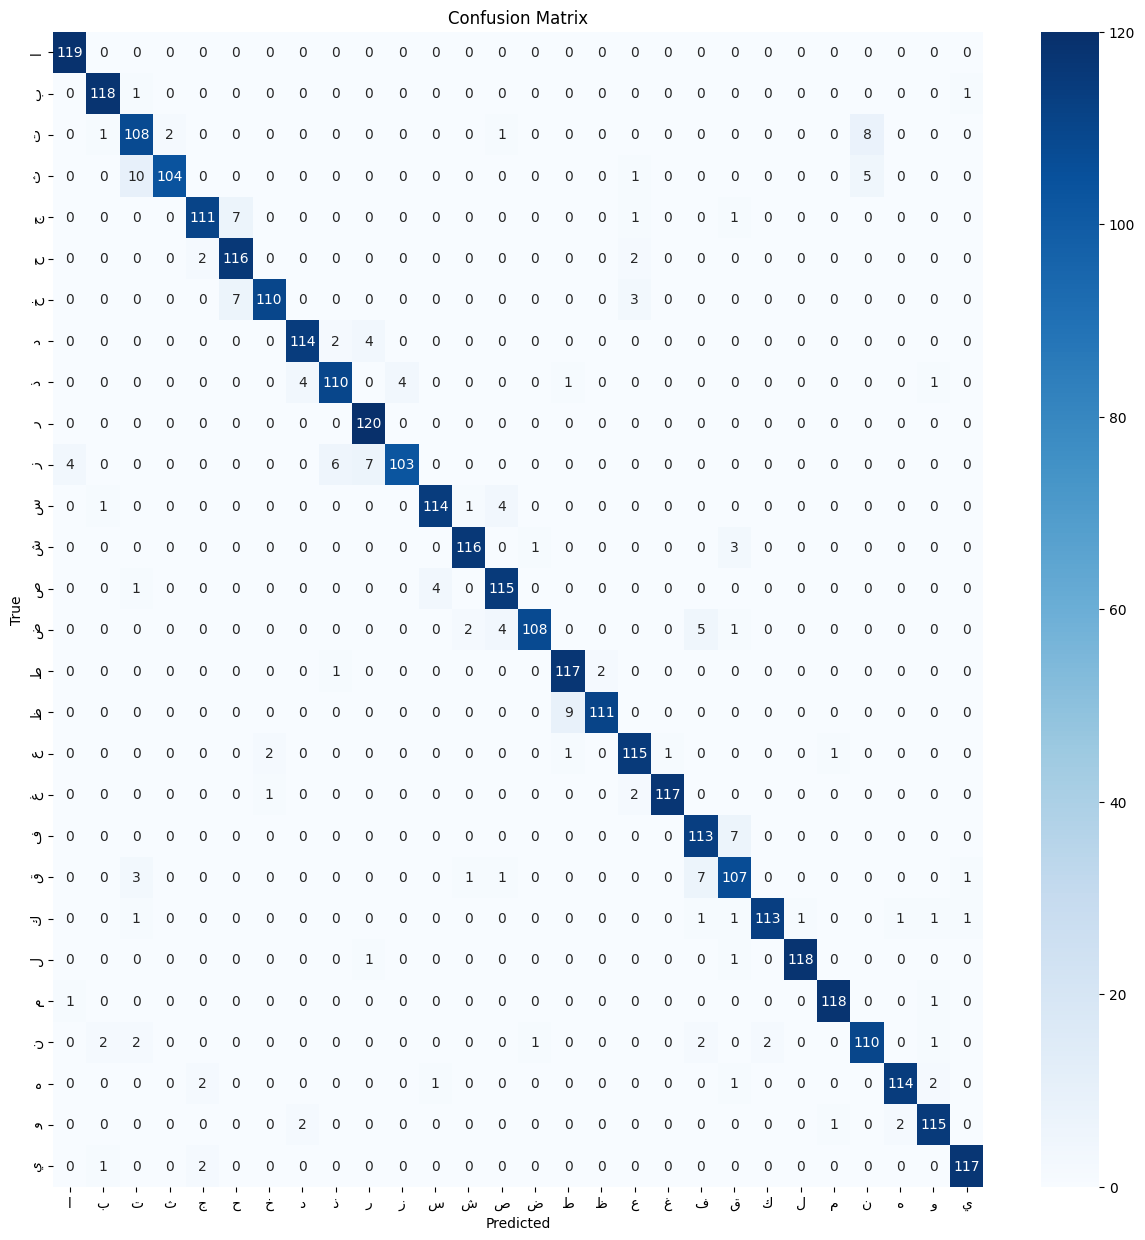

In [108]:
predicted_labels3_hash = [arabic_alphabet[idx] for idx in predicted_labels3]

cm = confusion_matrix(y_true1, predicted_labels3_hash)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_true1)), yticklabels=sorted(set(y_true1)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Task 4

For this task, we tried several pre-trained models, like VGG16 and EfficientNet, but they all resulted in bad accuracies. That is because of the dataset they are trained on, which is [imagenet](https://www.image-net.org/), it is not very related to our dataset, since it is a dataset for describing the images. We searched for English letters classification, since it is related to our dataset, and we found this [dataset](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format), and then searched for trained models and found this [model](https://www.kaggle.com/code/yairhadad1/cnn-for-handwritten-alphabets/output?select=my_model.h5). We uploaded it and processed transfer learning for our dataset.

In [121]:
model_path = '/kaggle/input/testing5/my_model.h5'
model = load_model(model_path)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               589952    
                                                                 
 dense_2 (Dense)             (None, 26)                3354      
                                                      

We can see that the model consists of 6 layers as the following:
* 1 convolutional layer.
* 1 max polling layer.
* 1 dropout layer.
* 1 flatten layer.
* 2 dense layers.


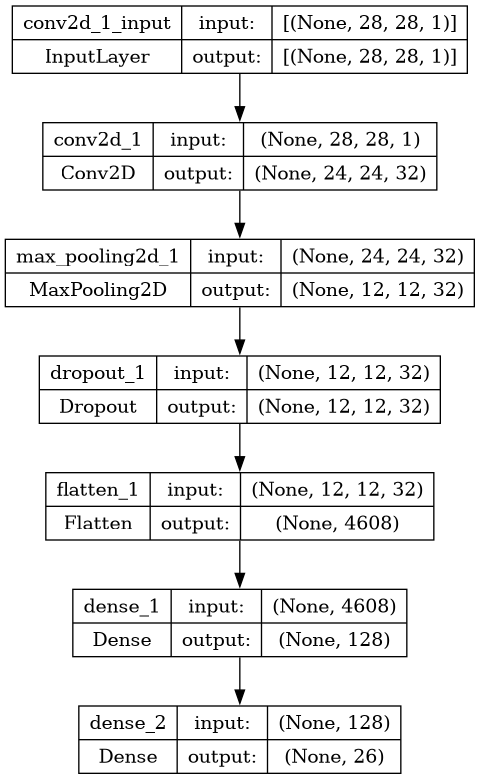

In [122]:
tf.keras.utils.plot_model(model, show_shapes=True)

We need to edit the input shape and the number of classes for the output layer, so we set them as non-trainable layers. We also added two Dense layers with 256 units, and another one with the number of classes which is 28. This process is called transfer learning or fine-tuning.

In [123]:
# Define a new input layer with shape (32, 32, 1)
new_input = Input(shape=(32, 32, 1))

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(new_input)

# Freeze the layers from the original model up to the second-to-last layer
for layer in model.layers[1:-3]:
    if layer == model.layers[len(model.layers) - 2]:
        continue
    layer.trainable = False
    x = layer(x)

# Add max pooling layer with a pool size of (2, 2)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Add batch normalization layer
x = BatchNormalization()(x)

x = Dropout(0.25)(x)

# Flatten the output
x = Flatten()(x)

# Add a fully connected layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add another fully connected layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add the output layer with num_classes units and softmax activation
output = Dense(num_classes, activation='softmax')(x)

# Create a new model with the specified input and output layers
model4 = Model(inputs=new_input, outputs=output)

# Display the summary of the new model
model4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_10 (Ba  (None, 7, 7, 32)          128

We can see non-trainable params, the ones we turned off.

## Running the model

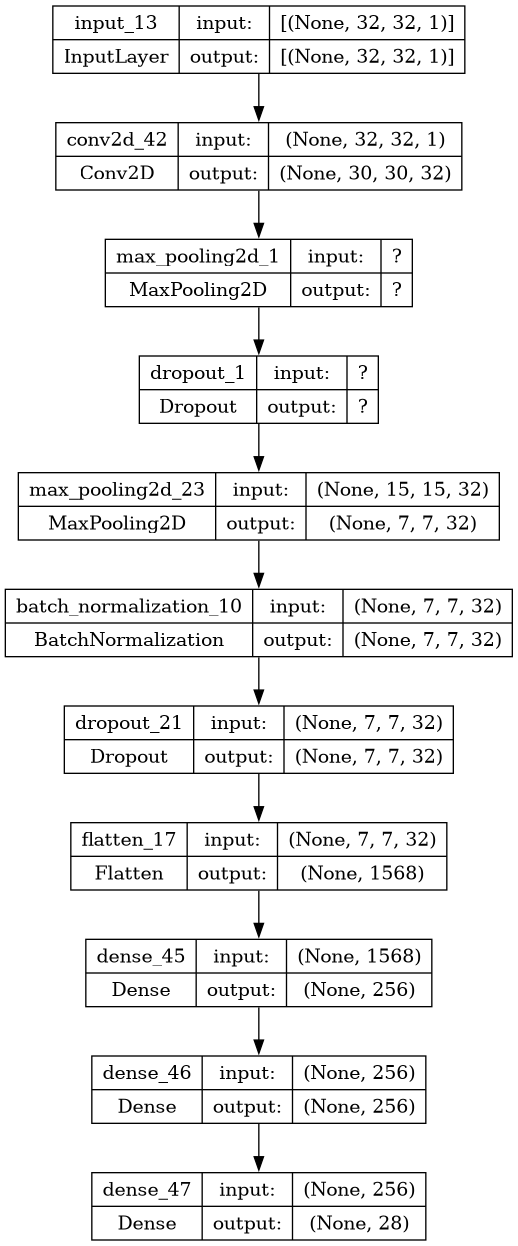

In [124]:
tf.keras.utils.plot_model(model4, show_shapes=True)

Epoch 1/300


2024-01-25 23:24:55.779929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


104/104 [==============================] - 6s 42ms/step - loss: 2.0369 - accuracy: 0.3839 - val_loss: 2.8247 - val_accuracy: 0.3025
Epoch 2/300
104/104 [==============================] - 4s 39ms/step - loss: 1.0458 - accuracy: 0.6495 - val_loss: 2.2551 - val_accuracy: 0.5668
Epoch 3/300
104/104 [==============================] - 4s 40ms/step - loss: 0.8018 - accuracy: 0.7277 - val_loss: 1.3982 - val_accuracy: 0.8422
Epoch 4/300
104/104 [==============================] - 4s 41ms/step - loss: 0.6707 - accuracy: 0.7733 - val_loss: 0.8588 - val_accuracy: 0.8476
Epoch 5/300
104/104 [==============================] - 4s 42ms/step - loss: 0.6060 - accuracy: 0.7911 - val_loss: 0.5191 - val_accuracy: 0.8449
Epoch 6/300
104/104 [==============================] - 5s 47ms/step - loss: 0.5485 - accuracy: 0.8085 - val_loss: 0.3296 - val_accuracy: 0.9009
Epoch 7/300
104/104 [==============================] - 4s 42ms/step - loss: 0.5026 - accuracy: 0.8288 - val_loss: 0.3385 - val_accuracy: 0.8812
Epoc

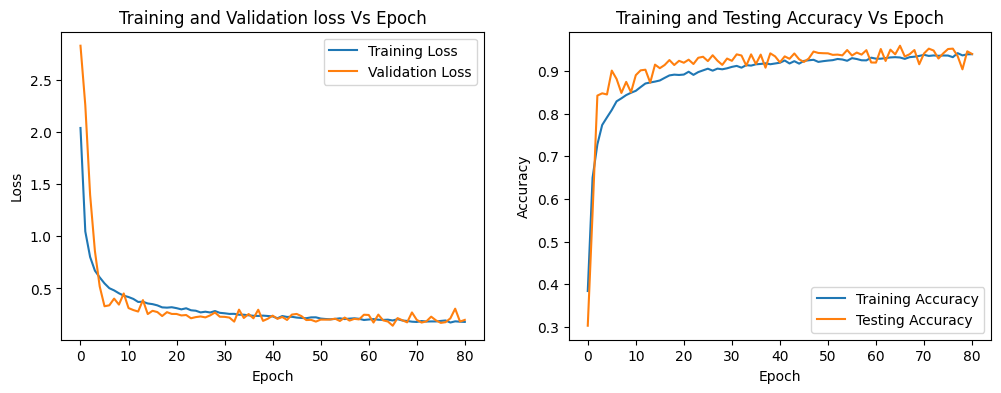

Training Accuracy: 97.54%
Testing Accuracy: 95.92%


In [125]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create an image data generator with various augmentations
image_generator4 = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1)

# Fit the image data generator on the training data
image_generator4.fit(X_train)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Train the model using the image data generator
hist4 = model4.fit(image_generator4.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train) / 128, epochs=300,
                    validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Plot the training history
plot_hist(hist4)

# Evaluate the trained model on the training set
train_loss4, train_accuracy4 = model4.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy4 * 100:.2f}%')

# Evaluate the trained model on the test set
test_loss4, test_accuracy4 = model4.evaluate(X_test, y_test, verbose=0)
print(f'Testing Accuracy: {test_accuracy4 * 100:.2f}%')

The outcomes from Task 4, employing a pre-trained model for English alphabet categorization in the context of Arabic Handwritten Character Recognition (AHCR), are notably encouraging. Despite the model's initial training on a distinct script, it demonstrated impressive performance, boasting a training accuracy of 97.54% and a testing accuracy of 95.92%.

This success underscores the model's capacity to generalize effectively to the AHCR task, showcasing the utility of transfer learning. The concept of transfer learning allows knowledge acquired from solving one problem, such as recognizing English alphabets, to be applied adeptly to a related yet different problem, such as recognizing Arabic characters.

The slightly lower testing accuracy in comparison to the custom CNN models from Tasks 1 and 2 might be attributed to inherent dissimilarities between Arabic and English scripts, along with potential differences in the datasets used for training. Nonetheless, the high testing accuracy implies the pre-trained model adapted well to the challenge of recognizing Arabic characters.

It's worth noting that in Task 4, the pre-trained model required 81 epochs for training, and this extended training duration likely played a crucial role in allowing the model to fine-tune its parameters and adapt to the specific nuances of the Arabic character recognition task. The effect of the increased number of epochs likely contributed to the model's enhanced performance on the AHCR task.

105/105 [==============================] - 0s 2ms/step


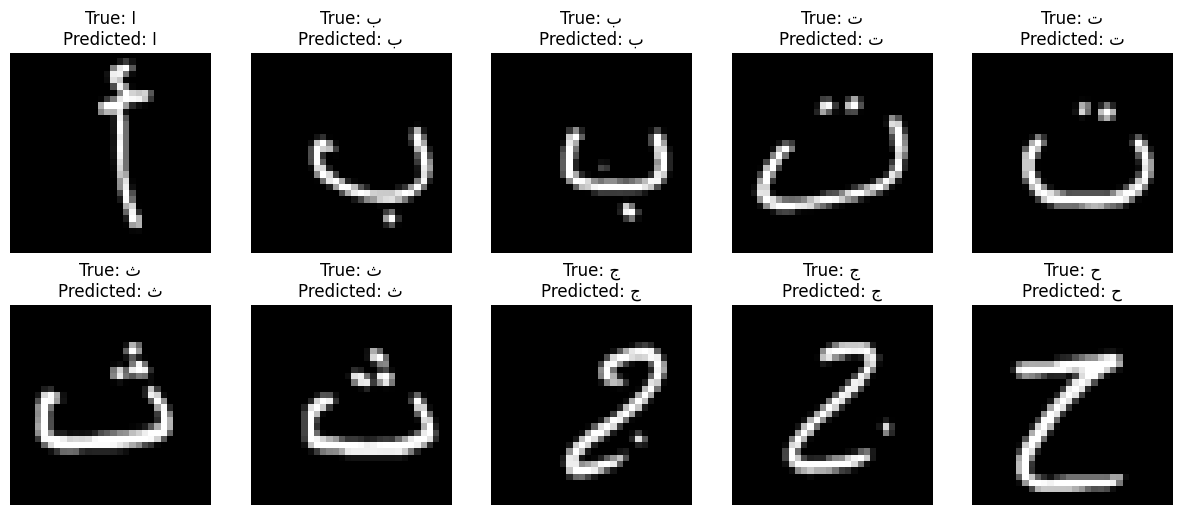

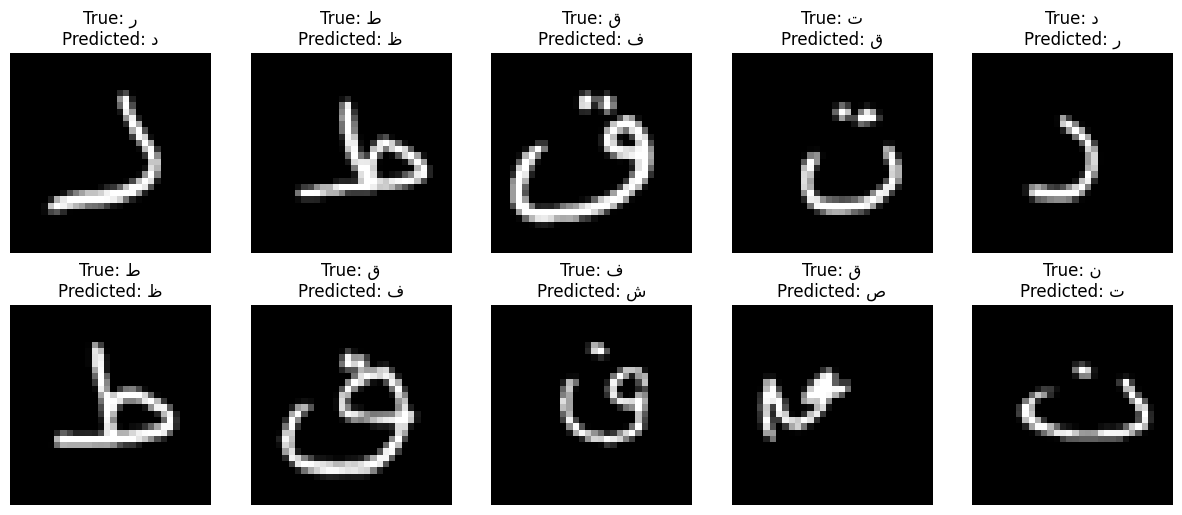

In [126]:
predictions4 = model4.predict(X_test)
predicted_labels4 = np.argmax(predictions4, axis=1)
plot_results(X_test, np.argmax(y_test, axis=1), predicted_labels4)

We can see correct predictions in the first 10 images and wrong predictions in the second 10 images.

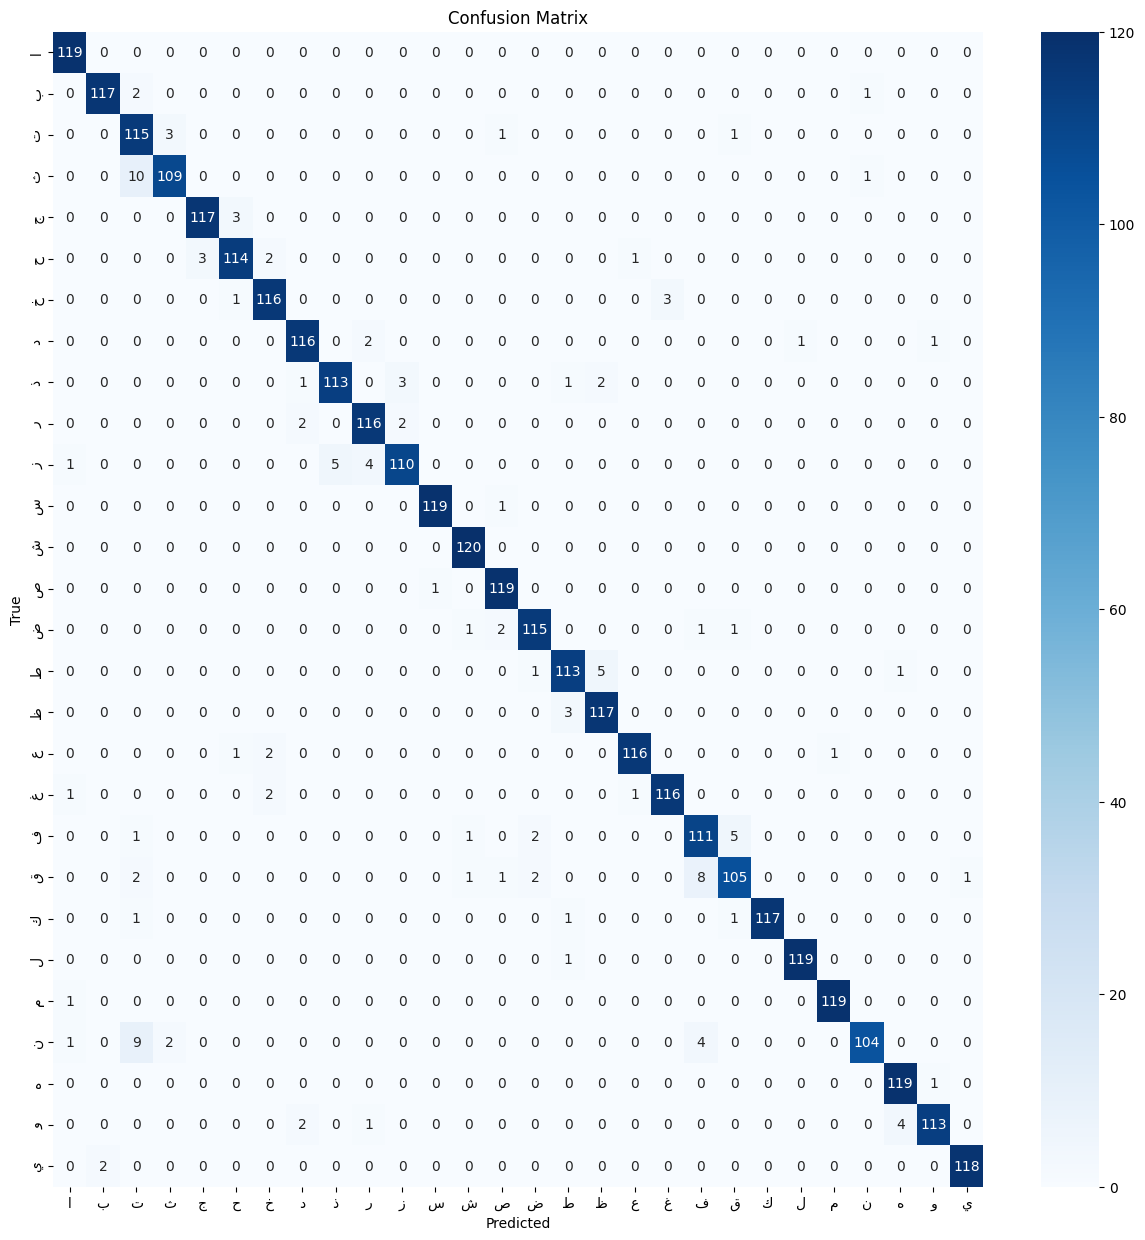

In [127]:
predicted_labels4_hash = [arabic_alphabet[idx] for idx in predicted_labels4]

cm = confusion_matrix(y_true1, predicted_labels4_hash)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_true1)), yticklabels=sorted(set(y_true1)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Conclusion

In conclusion, our exploration into Arabic Handwritten Character Recognition (AHCR) using Convolutional Neural Networks (CNNs) has yielded insightful findings across four distinct methodologies. Traditional techniques like K-nearest neighbors and Support Vector Machines have given way to advanced approaches, with deep learning, particularly CNNs, proving highly effective in handling the intricacies of Arabic script. The custom CNN model demonstrated high accuracy but raised concerns of potential overfitting, mitigated through early stopping. The introduction of data augmentation in the second approach showcased significant enhancements in accuracy and generalization. LeNet-5 architecture, despite a slightly lower accuracy, highlighted the challenge of finding an optimal model for the given dataset and script. Task 4 showcased the power of transfer learning, achieving commendable results by leveraging knowledge from English alphabet recognition. The longer training period for the pre-trained model emphasized the importance of extended epochs in adapting to the nuances of Arabic characters. In essence, this project underscores the evolving landscape of handwriting recognition, emphasizing the critical role of advanced machine learning techniques in unraveling the complexities of diverse scripts.